<a href="https://colab.research.google.com/github/TonyLiu836/Road-Network-Extraction-From-Satellite-Imagery/blob/main/Spacenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas    #==0.6.3   #latest version of geopandas changes CRS objects, 0.6.3 works when generating training masks - otherwise shouldnt matter
!pip install imagecodecs    
!pip install osmnx
!pip install scikit-image

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CSCI5525Project"
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSCI5525Project


'/content/drive/MyDrive/CSCI5525Project'

# Generate Binary Masks from Continuous Mask (Ran for Paris Dataset only)

In [ ]:
from os import walk
from glob import glob
import shutil 
from sklearn.model_selection import train_test_split
import re 

from google.colab.patches import cv2_imshow
"""
imgName = "SN3_roads_train_AOI_3_Paris_PS-MS_img48.tif"
path = "/content/drive/MyDrive/CSCI5525Project/experiment"
img_path = "/content/drive/MyDrive/CSCI5525Project/paris/paris_training_masks_contin/SN3_roads_train_AOI_3_Paris_PS-MS_img48.tif"
img_path2 = "/content/drive/MyDrive/CSCI5525Project/paris/paris_training_masks_contin/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif"
img = cv2.imread(img_path2)
print(img)
ret, bw_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
bw = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

#cv2_imshow(bw_img)
cv2.imwrite(os.path.join(path, imgName), bw_img)
"""


dir = "/content/drive/MyDrive/CSCI5525Project/paris/paris_training_masks_contin"
outputDir = "/content/drive/MyDrive/CSCI5525Project/paris/paris_train_mask_binary"
for (dirpath, dirname, filename) in walk(dir):
    for name in filename:
        new_name = name[:-4]
        img = cv2.imread(os.path.join(dir,name))
        ret, bw_img = cv2.threshold(img, 1,255, cv2.THRESH_BINARY)
        binary_mask = cv2.cvtColor(bw_img, cv2.COLOR_BGR2GRAY)          #convert to 1 channel instead of 3 channel
        binary_mask[binary_mask >= 1] = 255
        cv2.imwrite(os.path.join(outputDir, name), binary_mask)
        #print("here")
        #break

#mask = cv2.imread(mask_path)
#mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#mask = cv2.resize(mask, (286,286),interpolation = cv2.INTER_AREA)
    

In [ ]:
from PIL import Image   #PIL can't open 16bit images, only 8bit

im = Image.open('/content/drive/MyDrive/CSCI5525Project/SN3_roads_train_AOI_3_Paris_PS-RGB_img10.tif')
im.show()

In [ ]:
#!unzip /content/drive/MyDrive/CSCI5525Project/paris.zip -d /home

#!cp -r paris_PSMS_8bit /home
#!cp -r paris_geojson_roads_speed/ /home

cp: cannot stat 'paris_PSMS_8bit': No such file or directory
cp: cannot stat 'paris_geojson_roads_speed/': No such file or directory


In [ ]:
#DONT NEED TO RUN THIS 

"""
#convert 16-bit satellite images into 8-bit for Paris Dataset
!python create_8bit_images.py \
    --indir="/home/paris/AOI_3_Paris/PS-MS" \
    --outdir="/content/drive/MyDrive/CSCI5525Project/paris_PSMS_8bit" \
    --rescale_type=perc \
    --percentile=2,98 \
    --band_order=5,3,2

#create road speed mask for Paris Dataset 
!python speed_masks.py \
    --geojson_dir="/home/paris_geojson_roads_speed" \
    --image_dir="/home/paris_PSMS_8bit" \
    --output_conversion_csv_binned="/content/drive/MyDrive/CSCI5525Project/paris_roads_train_speed_conversion_binned.csv" \
    --output_mask_dir_contin="/content/drive/MyDrive/CSCI5525Project/paris_training_masks_contin" \
    --output_mask_multidim_dir="/content/drive/MyDrive/CSCI5525Project/paris_train_mask_binned_mc" \
    --buffer_distance_meters=2
"""

python3: can't open file 'create_8bit_images.py': [Errno 2] No such file or directory
python3: can't open file 'speed_masks.py': [Errno 2] No such file or directory


# Visualize Sample and training mask





im shape (1300, 1300, 3)
multi-channel mask shape: (1300, 1300, 8)
channels 3
1690000


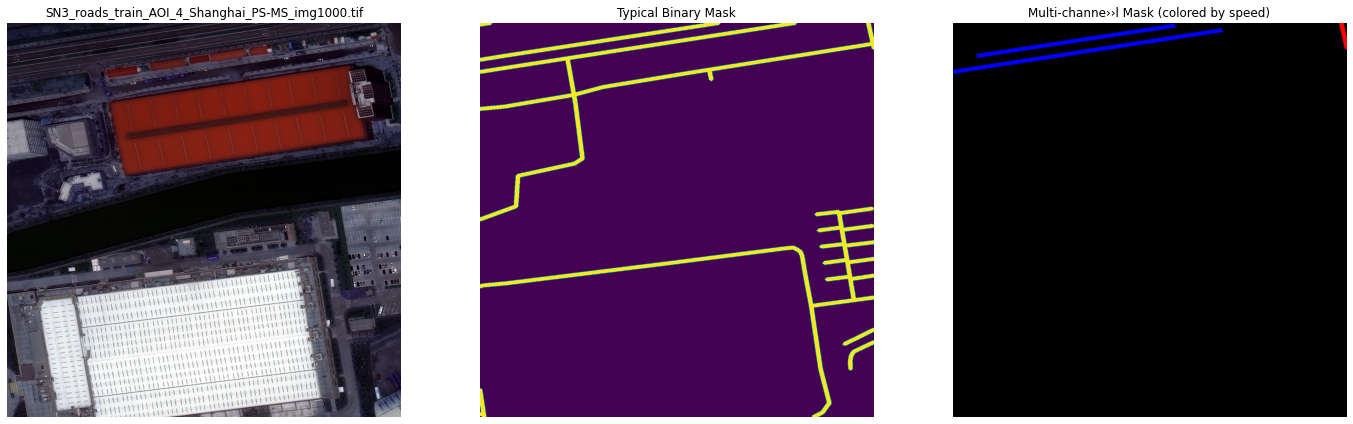

In [ ]:
#visualize multi-channel mask 
import os
import cv2

import numpy as np
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import skimage.io

#im_dir = '/content/drive/MyDrive/CSCI5525Project/paris/paris_PSMS_8bit'
im_dir = '/content/drive/MyDrive/CSCI5525Project/test_data/shanghai_PSMS_8bit'
#mask_dir = '/content/drive/MyDrive/CSCI5525Project/paris/paris_train_mask_binned_mc'
mask_dir = '/content/drive/MyDrive/CSCI5525Project/test_data/shanghai_masks'
#im_name = 'SN3_roads_train_AOI_3_Paris_PS-MS_img35.tif'
im_name = "SN3_roads_train_AOI_4_Shanghai_PS-MS_img1000.tif"
im_path = os.path.join(im_dir, im_name)
mask_mc_path = os.path.join(mask_dir, im_name)

# plot
fig, ((ax0, ax1, ax2)) = plt.subplots(1,3, figsize=(24,9))

# image
im = cv2.imread(im_path, 1)
ax0.imshow(cv2.imread(im_path, 1))
print("im shape",np.shape(im))        #1300x1300x3
ax0.axis('off')
ax0.set_title(im_name)

mask_mc = skimage.io.imread(mask_mc_path)
print("multi-channel mask shape:", mask_mc.shape)

# binary mask
ax1.imshow(mask_mc[:,:,-1])
ax1.axis('off')
ax1.set_title('Typical Binary Mask')

# 8 channel mask
z = ax2.imshow(mask_mc[:,:,2:5])
ax2.axis('off')
ax2.set_title('Multi-channe››l Mask (colored by speed)')    


print('channels', len(im.shape))

from PIL import Image

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width*height

print(get_num_pixels("/content/drive/MyDrive/CSCI5525Project/paris/paris_PSMS_8bit/SN3_roads_train_AOI_3_Paris_PS-MS_img35.tif"))


In [ ]:
"""
from PIL import Image
img = "/content/drive/MyDrive/CSCI5525Project/paris/paris_train_mask_binned_mc/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif"
img2 = "/content/drive/MyDrive/CSCI5525Project/paris/paris_PSMS_8bit/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif"
im = Image.open(img2)
im.show()
"""
from google.colab.patches import cv2_imshow
imgName = "SN3_roads_train_AOI_3_Paris_PS-MS_img48.tif"
path = "/content/drive/MyDrive/CSCI5525Project/experiment"
img_path = "/content/drive/MyDrive/CSCI5525Project/paris/paris_training_masks_contin/SN3_roads_train_AOI_3_Paris_PS-MS_img48.tif"
img_path2 = "/content/drive/MyDrive/CSCI5525Project/paris/paris_training_masks_contin/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif"
img = cv2.imread(img_path2)
ret, bw_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
bw = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

#cv2_imshow(bw_img)
cv2.imwrite(os.path.join(path, imgName), bw_img)
print(get_num_pixels("/content/drive/MyDrive/CSCI5525Project/paris/paris_train_mask_binary/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif"))

print(get_num_pixels("/content/drive/MyDrive/3band_AOI_1_RIO_img6932.tif"))

1690000
178673


# Dataset & Dataloader


In [2]:
import os
import math
import numpy as np 
from PIL import Image
import cv2
from pathlib import Path
import time
import argparse
import logging 


import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm
import torch
import torch.nn as nn   #defines pre-existing set of neural networks
import torch.nn.functional as F   #defines set of functions, that pytorch knows how to autodiff
import torch.utils.data as data   
import torch.optim as optim       
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from pathlib import Path

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

#ensure all operations are deterministic on GPU for reproducible results
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [3]:
img_size = (256,256)      # can change later on, resizing images from 1300x1300x3 to 256x256x3 initially

class citiesDataset(Dataset):
    def __init__(self, mode, img_dir, mask_dir, scale = 1, transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.scale = scale 
        self.img_list = []
        self.mode = mode            #train/test model 

        #img_path = Path(os.path.dirname(__file__) + img_dir)      #img path 

        #adds names of all images into list 
        #for name in os.listdir(img_path):
        for name in os.listdir(self.img_dir):
            #print("NAME", name)
            #print("combined name =", os.path.join(self.img_dir, name))
            if os.path.isfile(os.path.join(self.img_dir, name)):
                self.img_list.append(name)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_list[index])
        #img_path = os.getcwd() + img_path
        #print("img_path", img_path)
        img = np.array(Image.open(img_path))
        img = cv2.resize(img, (img_size), interpolation = cv2.INTER_AREA)
        img = np.transpose(img, (2,0,1))    #change img shape from HxWxC to CxHxW (need to match with conv2d dims)
        #img = np.divide(img, 255.0)
        # need to also include normalization of images here**************************************** (still need to figure this out)

        if self.mode == "train":
            mask_path = os.path.join(self.mask_dir, self.img_list[index])
            #mask_path = os.getcwd() + mask_path

            #mask = np.array

            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            mask = cv2.resize(mask, (256,256),interpolation = cv2.INTER_AREA)   #resize imgs
            mask[mask >= 1] = 255

            mask = np.expand_dims(mask, axis=0)
            
            #mask = np.divide(mask, 255.0)
            sample = {'image': torch.from_numpy(img).type(torch.FloatTensor), 'mask': torch.from_numpy(mask).type(torch.FloatTensor), 'image_name': self.img_list[index]}

        elif self.mode == "test":
            sample = {'image': img, 'image_name': img}

        return sample


#test datasets class
#city_path = "/content/drive/MyDrive/CSCI5525Project/paris_small"          
#mask_path = "/content/drive/MyDrive/CSCI5525Project/paris_small/paris_train_mask_binary"

#parisDataset = citiesDataset("train", img_path, mask_path)
#print(len(parisDataset))
#for i in range(len(parisDataset)):
#    print(parisDataset[i]["image_name"])

#dataset class seems to be working correctly 

# UNet(base network)

In [4]:

# conv block
class ConvBlock(nn.Module):
    def __init__(self, input_ch, output_ch):
        super().__init__()

        self.conv1 = nn.Conv2d(input_ch, output_ch, kernel_size=3, padding= "same")
        self.batchnorm1 = nn.BatchNorm2d(output_ch)
        self.conv2 = nn.Conv2d(output_ch, output_ch, kernel_size=3, padding= "same")
        self.batchnorm2 = nn.BatchNorm2d(output_ch)
        self.relu = nn.ReLU()

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity = "relu")
        
    
    def forward(self, x):
        x = self.batchnorm1(self.relu(self.conv1(x)))
        
        x = self.batchnorm2(self.relu(self.conv2(x)))
        return x
        
'''
enc_block = ConvBlock(1,64)
x = torch.randn(1,1,572,572)
print(enc_block(x).shape)
'''

#encChannels = [3,64,128,256,512,1024]
#final_channels = 512

encChannels = [3,64,128,256,512]
class Encoder(nn.Module):
    def __init__(self, channels=encChannels):
        super().__init__()
        #self.enc_block = nn.Module()
        self.encBlocks = nn.ModuleList([ConvBlock(encChannels[i], encChannels[i+1]) for i in range(len(encChannels)-1)])
        #self.iniConv = nn.Conv2d(3, 32, kernel = 3)

        self.convEnc1 = nn.Conv2d(encChannels[-1], encChannels[-1], kernel_size=3, padding= "same")     #2 convs after the encoding step
        self.convEnc2 = nn.Conv2d(encChannels[-1], encChannels[-1], kernel_size=3, padding= "same")
        

        self.batchnorm = nn.BatchNorm2d(encChannels[-1])
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()


        nn.init.kaiming_normal_(self.convEnc1.weight, nonlinearity = "relu")
        nn.init.kaiming_normal_(self.convEnc2.weight, nonlinearity = "relu")


    def forward(self, x):
        features = []                       #skip connections

        for block in self.encBlocks: 
            x = block(x)
            features.append(x)
            #print("pool")
            x = self.pool(x)

        x = self.batchnorm(self.relu(self.convEnc1(x)))
        x = self.batchnorm(self.relu(self.convEnc2(x)))
        #print("x shape final", x.shape)
        return features                  

'''
encoder = Encoder()
x = torch.randn(1,3, 256, 256)
features = encoder(x)
for output in features:
    print(output.shape)
'''

#decChannels = [1024, 512,256,128,64]
decChannels = [512,256, 128, 64]
#upSampleChannels = [512,256, 128, 64,3]
class Decoder(nn.Module):
    def __init__(self, channels = decChannels): 
    #def __init__(self, channels = upSampleChannels):#channels_seq[::-1]):
        super().__init__()
        self.channels = channels
        self.upSample = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i+1], 2,2) for i in range(len(channels)-1)])
        #self.decBlocks = nn.ModuleList([ConvBlock(decChannels[i], decChannels[i+1]) for i in range(len(decChannels)-1)])
        self.decBlocks = nn.ModuleList([ConvBlock(decChannels[i], decChannels[i+1]) for i in range(len(decChannels)-1)])

    
    def crop(self, feature, x):
        _,_,H,W = x.shape
        features = transforms.CenterCrop([H,W])(feature)   #crops the features to be the same shape as x (accounts for loss of border pixels, not sure if needed when padding is used in conv)

        return features

    def forward(self,x, features):   
        for i in range(len(decChannels)-1):
            #print("x shape", x.shape)
            #print("feature[i] shape", features[i].shape)
            x = self.upSample[i](x)
            
            skipCon = self.crop(features[i], x)

            x = torch.cat([x, skipCon], dim = 1)
            x = self.decBlocks[i](x)
        
        return x


class UNet(nn.Module):
    def __init__(self, encChans = encChannels, decChans = decChannels, numClasses = 1, retainDim = True, outputSize = img_size):
        super().__init__()
        self.encoder = Encoder(encChans)
        self.decoder = Decoder(decChans)
        self.head = nn.Conv2d(decChans[-1], numClasses,1)
        self.retainDim = retainDim
        self.outputSize = outputSize

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features[::-1][0], features[::-1][1:])            #
        output = self.head(output)

        if self.retainDim:
            otuput = F.interpolate(output, self.outputSize)
        
        return output


"""
unetTest = UNet()
x = torch.randn(4,3,256,256)
unetTest(x).shape
"""


'\nunetTest = UNet()\nx = torch.randn(4,3,256,256)\nunetTest(x).shape\n'

According to DA-Roadnet, shallow encoder-decoder network minimizes loss of road structure information (only maxpool 3 times)

In [15]:
"""
decoder = Decoder()
#x = torch.randn(1,1024,28,28)
x = torch.randn(1,512,32,32)
for i in features[::-1][1:]:
    print(i.shape)
#print(features[::-1][1:].shape)
decoder(x, features[::-1][1:]).shape
"""

'''
unet = UNet()
x = torch.randn(1,3,572,572)
unet(x).shape
'''


#taken from https://github.com/kevinzakka/pytorch-goodies
def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:

        #print(true.squeeze(1).type())
        #print(true.squeeze(1).size())
        
        #print(num_classes + 1)
        #print(true.byte().type())
        #print((true/255).long().size())
        true_1_hot = torch.eye(num_classes + 1)[(true.squeeze(1)/255).long()]
        #true_1_hot = F.one_hot((true/255).long() , num_classes + 1)
        #print(true_1_hot.size())
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


In [43]:
#train Unet (base)

import datetime
import os
from google.colab.patches import cv2_imshow

NOW = datetime.date.today()
dateTime = str(NOW)
"""
#path = "/content/gdrive/MyDrive/log"
#print(NOW)
#print(f"date and time {dateTime}")

#print(os.path.join(chckpt_path, dateTime))
"""

#change these accordingly

 
#used for experimenting to verify everything works
ckpt_path = "/content/drive/MyDrive/CSCI5525Project/checkpoints"
city_path = "/content/drive/MyDrive/CSCI5525Project/paris_small"          
img_path = "/content/drive/MyDrive/CSCI5525Project/paris_small/paris_PSMS_8bit"
#img_path = "paris_PSMS_8bit"

mask_path = "/content/drive/MyDrive/CSCI5525Project/paris_small/paris_train_mask_binary"
#mask_path = "paris_train_mask_binary"
"""

ckpt_path = "/content/drive/MyDrive/CSCI5525Project/checkpoints"
city_path = "/content/drive/MyDrive/CSCI5525Project/paris"
img_path = "/content/drive/MyDrive/CSCI5525Project/paris/paris_PSMS_8bit"
mask_path = "/content/drive/MyDrive/CSCI5525Project/paris/paris_train_mask_binary"
"""
#dataset class takes the following params: mode, img_dir, mask_dir, scale = 1, transform = None
parisDataset = citiesDataset("train", img_path, mask_path)


batch_size = 64
val_split = 0.3
shuffle = True
random_seed = 42

#OG found here: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887

# Creating data indices for training and validation splits:
dataset_size = len(parisDataset)
#print("dataset size= ", dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#print(train_indices, val_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(parisDataset, batch_size=batch_size, sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(parisDataset, batch_size=batch_size,sampler=valid_sampler)

#train_loader = torch.utils.data.DataLoader(parisDataset, batch_size=4, sampler=train_sampler)

#validation_loader = torch.utils.data.DataLoader(parisDataset, batch_size=4, sampler=valid_sampler) 

#used to normalize training images 
def get_mean_std(dataloader): 
    chanSum, chanSquareSum, numBatches = 0,0,0

    for data, _ in dataloader:
        chanSum += torch.mean(data, dim= [0,2,3])
        chanSquareSum += torch.mean(data**2, dim=[0,2,3])
        numBatches += 1

    mean = chanSum / numBatches
    std = ((chanSquareSum / numBatches)  - mean**2) ** 0.5

    return mean, std

unet = UNet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience = 2) #set to max here bc we want to maximize dice score 
#loss_module = 
#loss = TverskyLoss()       try with BCEWLogitsLoss 

loss_module = nn.BCEWithLogitsLoss()
#loss_module = TverskyLoss(alpha = , beta = )

#loss_module = DiceLoss()
#loss_module = nn.CrossEntropyLoss()
def trainUNet(model, optimizer, train_loader, valid_loader):

    #batchSize = 64
    numEpochs = 1
    
    for epoch in range(numEpochs):
        model.train()
        trainLoss = []
        for sample in train_loader:
            #print(len(data_loader.dataset))
            #asdf
            #img = img.to(device)
            #mask = mask.to(device)
            img = sample["image"].to(device, dtype = torch.float32)
            mask = sample["mask"].to(device, dtype = torch.float32)
            prediction = model(img)
            loss = loss_module(prediction, mask)
            #loss = dice_loss(mask, prediction)

            lossValue = loss.item()

            optimizer.zero_grad()
            loss.backward()

            #maybe need gradient clipping here? 

            optimizer.step()
            #trainLoss.append(loss)
            trainLoss.append(lossValue)

            print(f"[Epoch {epoch+1:2d}] Loss: {loss}")
            #print(f"[Epoch {epoch+1:2d}] Loss: {lossValue}")
        #path to save training checkpoints
    

    
    ckptDir = os.path.join(ckpt_path, dateTime)      #makes folder with current date in checkpoints folder 

    if os.path.isdir(ckptDir):
        #folder with current data exists
        modelPath = os.path.join(ckptDir, 'model-%05d.ckpt'%epoch)
        torch.save(model.state_dict(), modelPath)
    else:
        #folder with current data doesnt exist
        os.mkdir(ckptDir)

        modelPath = os.path.join(ckptDir, 'model-%05d.ckpt'%epoch)
        torch.save(model.state_dict(), modelPath)


    model.eval()
    with torch.no_grad():
        validLoss = []

        for sample in valid_loader:
            img = sample["image"].to(device, dtype = torch.float32)
            mask = sample["mask"].to(device, dtype = torch.float32)

            valPred = model(img)
            #print(valPred.shape)
            #valLoss = loss_module(mask, valPred)
            valLoss = dice_loss(mask, valPred)
            validLoss.append(valLoss.item())
        
        scheduler.step(validLoss[-1])

        #print(img.shape)        #torch.Size([3, 3, 256, 256])
        #print(valPred.shape)    #torch.Size([3, 1, 256, 256])
        #print(mask.shape)       #torch.Size([3, 1, 256, 256])

        
        img_vis = np.squeeze(img.cpu().numpy()[0]).transpose((1,2,0)).astype(int)
        pred_vis = np.squeeze(torch.sigmoid(valPred).cpu().numpy()[0]) * 255
        mask_vis = np.squeeze(mask.cpu().numpy()[0])
        
        #print(img_vis.shape, "   type", img_vis.dtype)
        
        #print(pred_vis.shape)
        #print(mask_vis.shape)
        #fig, axis = plt.subplots(1,3)
        cv2_imshow(img_vis)
        cv2_imshow(pred_vis)
        cv2_imshow(mask_vis)
        #axis[0].imshow(img_vis)
        #axis[1].imshow(pred_vis)
        #axis[2].imshow(mask_vis)

        #plt.figure()
        #plt.imshow(img_vis) 
        #plt.show()  # display it


def parseArgs():
    parser = argparse.ArgumentParser(description= "Train/test UNet")
    parser.add_argument('--mode', type = str, default = "train", help='Retain, train, or test UNet model', choices=["retrain", "train", "test"])
    parser.add_argument('--save', type=str, default = 'trained_models')
    parser.add_argument('--load', type=str, default = None)

    return parser.parse_args()




[Epoch  1] Loss: -0.8705402612686157


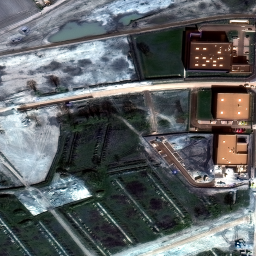

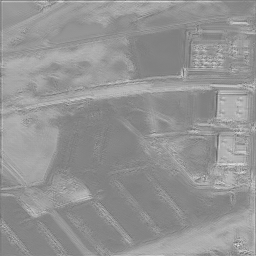

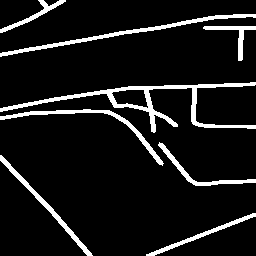

In [44]:
#trainUNet(unet, optimizer, train_loader, validation_loader ,loss_module)
trainUNet(unet, optimizer, train_loader, validation_loader)

In [ ]:
"""
from os.path import exists
path1 = "/content/drive/MyDrive/CSCI5525Project/paris_small/paris_PSMS_8bit/SN3_roads_train_AOI_3_Paris_PS-MS_img19.tif"
path2 = "/content/drive/MyDrive/CSCI5525Project/content/drive/MyDrive/CSCI5525Project/paris_small/paris_PSMS_8bit/SN3_roads_train_AOI_3_Paris_PS-MS_img19.tif"
file_exists = exists('/content/drive/MyDrive/CSCI5525Project/content/drive/MyDrive/CSCI5525Project/paris_small/paris_PSMS_8bit/SN3_roads_train_AOI_3_Paris_PS-MS_img19.tif')
print(file_exists)
"""
#verifying that the dataloader is working properly 
for sample in validation_loader:
    for i in range(len(sample['image'])):
        img = sample['image'].cpu().numpy()[i].transpose(1,2,0)
        cv2_imshow(img)
        mask = sample['mask'].cpu().numpy()[i].transpose(1,2,0)
        #print(mask.shape)
        cv2_imshow(mask)
        #cv2_imshow(mask_vis)

False


# UNet (with dense layers & attention)

In [ ]:
#used for dense block 
"""
class DenseLayer(nn.Module):
    def __init__(self, input_ch, output_ch):
        super().__init__()
        self.batchNorm = nn.BatchNorm2d(input_ch)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_ch, output_ch, kernel_size = 3, padding = 1)

    def forward(self,x):
        output = self.conv1(self.relu(self.batchNorm(x)))
        return torch.cat([x,output], 1)
"""
#DA-Roads paper used 4 dense/transition layers for each dense block
# not sure if we have to use this if we are using attention mechanism as well (DA-Roads paper used both) 

def convLayer(inputChannels, numChannels):
    return nn.Sequential(nn.BatchNorm2d(inputChannels), nn.ReLU(), nn.Conv2d(inputChannels, numChannels, kernel_size = 3, padding = 1))


class DenseBlock():
    def __init__(self, numConvs, inputChannels, numChannels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(numConvs):
            layer.append(convLayer(numChannels * i + inputChannels, numChannels))
        self.net = nn.Sequential(*layer)

    
    def forward(self, x):
        for block in self.net:
            Y = block(x)
            #cancat input & output of each block on the channel dimension 

            X = torch.cat((X,Y), dim=1)
        return X

def transitionLayer(inputChannels, numChannels):
    return nn.Sequential(nn.BatchNorm2d(inputChannels), nn.ReLU(), nn.Conv2d(inputChannels, numChannels, kernel_size = 1), nn.AvgPool2d(kernel_size=2, stride = 2))


#used for dense block
class TransitionLayer(nn.Module):
    def __init__(self, input_ch, output_ch):
        super().__init__()
        self.batchNorm = nn.BatchNorm2d(input_ch)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_ch, output_ch, kernel_size = 1, padding = 0)
    
    def forward(self, x):
        output = self.conv1(self.relu(self.batchNorm(x)))

        return F.avg_pool2d(output, 2)


# conv block
class ConvBlock(nn.Module):
    def __init__(self, input_ch, output_ch):
        super().__init__()

        self.conv1 = nn.Conv2d(input_ch, output_ch, kernel_size=3, padding= "same")
        self.conv2 = nn.Conv2d(output_ch, output_ch, kernel_size=3, padding= "same")
        self.relu = nn.ReLU()

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity = "relu")
        
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x
        

'''
enc_block = ConvBlock(1,64)
x = torch.randn(1,1,572,572)
print(enc_block(x).shape)
'''

#encChannels = [3,64,128,256,512,1024]
encChannels = [3,64,128,256,512]
#final_channels = 512
class Encoder(nn.Module):
    def __init__(self, channels=encChannels):
        super().__init__()
        #self.enc_block = nn.Module()
        self.encBlocks = nn.ModuleList([ConvBlock(encChannels[i], encChannels[i+1]) for i in range(len(encChannels)-1)])
        #self.iniConv = nn.Conv2d(3, 32, kernel = 3)

        self.convEnc1 = nn.Conv2d(encChannels[-1], encChannels[-1], kernel_size=3, padding= "same")     #2 convs after the encoding step
        self.convEnc2 = nn.Conv2d(encChannels[-1], encChannels[-1], kernel_size=3, padding= "same")
        
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()


        nn.init.kaiming_normal_(self.convEnc1.weight, nonlinearity = "relu")
        nn.init.kaiming_normal_(self.convEnc2.weight, nonlinearity = "relu")


    def forward(self, x):
        features = []                       #skip connections

        for block in self.encBlocks: 
            x = block(x)
            features.append(x)
            #print("pool")
            x = self.pool(x)

        x = self.relu(self.convEnc1(x))
        x = self.relu(self.convEnc2(x))
        print("x shape final", x.shape)
        return features                  

encoder = Encoder()
x = torch.randn(1,3, 256, 256)
features = encoder(x)
for output in features:
    print(output.shape)


#decChannels = [1024, 512,256,128,64]
decChannels = [512,256, 128, 64]
#upSampleChannels = [512,256, 128, 64,3]
class Decoder(nn.Module):
    def __init__(self, channels = decChannels): 
    #def __init__(self, channels = upSampleChannels):#channels_seq[::-1]):
        super().__init__()
        self.channels = channels
        self.upSample = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i+1], 2,2) for i in range(len(channels)-1)])
        #self.decBlocks = nn.ModuleList([ConvBlock(decChannels[i], decChannels[i+1]) for i in range(len(decChannels)-1)])
        self.decBlocks = nn.ModuleList([ConvBlock(decChannels[i], decChannels[i+1]) for i in range(len(decChannels)-1)])

    
    def crop(self, feature, x):
        _,_,H,W = x.shape
        features = transforms.CenterCrop([H,W])(feature)   #crops the features to be the same shape as x (accounts for loss of border pixels, not sure if needed when padding is used in conv)

        return features

    def forward(self,x, features):   
        for i in range(len(decChannels)-1):
            print("x shape", x.shape)
            print("feature[i] shape", features[i].shape)
            x = self.upSample[i](x)
            
            skipCon = self.crop(features[i], x)

            x = torch.cat([x, skipCon], dim = 1)
            x = self.decBlocks[i](x)
        
        return x


class UNet(nn.Module):
    def __init__(self, encChans = encChannels, decChans = decChannels, numClasses = 2, retainDim = True, outputSize = img_size):
        super().__init__()
        self.encoder = Encoder(encChans)
        self.decoder = Decoder(decChans)
        self.head = nn.Conv2d(decChans[-1], numClasses,1)
        self.retainDim = retainDim
        self.outputSize = outputSize

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features[::-1][0], features[::-1][1:])            #
        output = self.head(output)

        if self.retainDim:
            otuput = F.interpolate(output, self.outputSize)
        
        return output

